# Image colorization using CNN

Cose da fare:
 - Trainare con tutto il dataset

In [1]:
!pip install kornia

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 4.3 MB/s eta 0:00:00


In [29]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import pickle
import kornia

from statistics import mean
from skimage.color import rgb2lab

import time

from matplotlib.colors import LogNorm

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, models
import torch.utils.data as data_utils
from torchvision.transforms import v2

In [3]:
torch.cuda.is_available()

True

In [4]:
if torch.cuda.is_available():
  device = torch.device("cuda") #to use gpu

# Import and preprocess dataset (CIFAR10)
In this section, we import the dataset and process it properly. We discard the labels (we don't care about them since our goal is colorization, not classification) and set up a new dataset whose features are the L channel and whose labels are the AB channels. We then set up a Dataloader to process the data in batches.


In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
#Transform to LAB and separate the L and (a,b) channels
class RGB_to_LAB:
  def __call__(self, sample):
    # tensor = kornia.color.rgb_to_lab(sample) # 3 x 32 x 32
    tensor = rgb2lab(sample.numpy(), channel_axis=0) # 3 x 32 x 32
    tensor = torch.tensor(tensor)
    l = tensor[0, : , :]
    bw = torch.empty([3, 32, 32])
    bw[0, : , :] = l
    bw[1, : , :] = l
    bw[2, : , :] = l
    return bw, tensor[1:, :, :]

#Function to switch back to rgb
def LAB_to_RGB(l_tensor, ab_tensor):
  tensor = torch.cat([torch.unsqueeze(l_tensor,0), ab_tensor], dim = 0)
  tensor = kornia.color.lab_to_rgb(tensor)
  return tensor

transform_rgb_lab = RGB_to_LAB()
composed = transforms.Compose([transforms.ToTensor(), transform_rgb_lab])       # qui forse non serve piu la transformazione .ToTensor()
# composed = transforms.Compose([transforms.ToTensor()])

In [7]:
#Load dataset --> set download = True if it's the first time you're opening it
dataset = CIFAR10(root = "/content/gdrive/My Drive/CIFAR10", download = False,
                  transform = composed, train = True)

In [8]:
#Load dataset --> set download = True if it's the first time you're opening it
dataset_truth = CIFAR10(root = "/content/gdrive/My Drive/CIFAR10", download = False, train = True)


 Canale L: 0


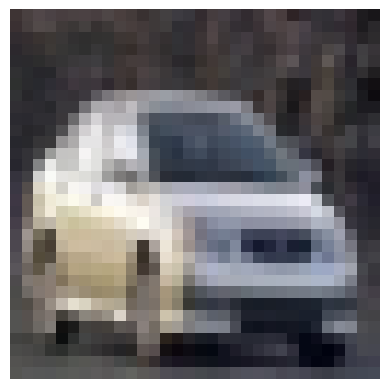


 Canale L: 1


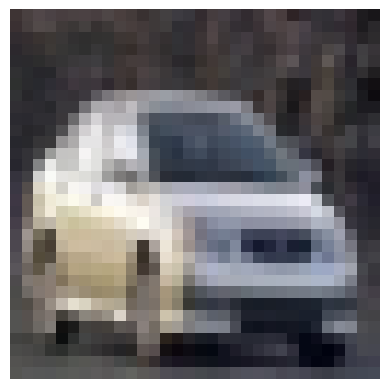


 Canale L: 2


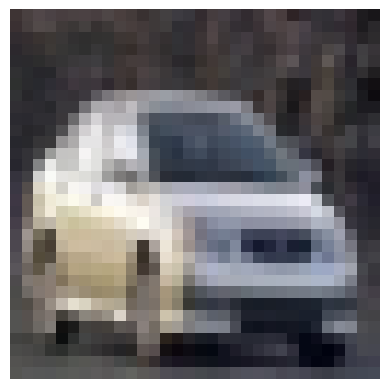


 Truth image: 2


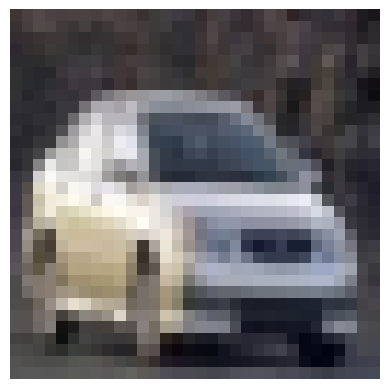

In [9]:
i = 15386 #show an image

for j in (0,1,2):
  img = LAB_to_RGB(dataset[i][0][0][j], dataset[i][0][1])

  rgb_image = np.transpose(img, (1, 2, 0))
  print('\n', 'Canale L:', j)
  plt.imshow(rgb_image)
  plt.axis('off')  # Turn off axis
  plt.show()

print('\n', 'Truth image:', j)
plt.imshow(dataset_truth[i][0])
plt.axis('off')  # Turn off axis
plt.show()


In [10]:
dataset[0]

((tensor([[[25.9628, 18.6144, 19.9091,  ..., 56.9342, 54.3470, 53.6980],
           [ 5.9704,  0.0000,  2.7306,  ..., 40.3564, 38.4452, 39.9988],
           [ 8.2543,  2.3679, 12.3160,  ..., 38.5917, 38.8377, 34.3636],
           ...,
           [71.5593, 65.9957, 67.7045,  ..., 56.7743, 14.6035, 15.2312],
           [60.7948, 55.2976, 62.0676,  ..., 63.4915, 29.6702, 25.2634],
           [62.1311, 56.9144, 61.3247,  ..., 76.5428, 52.0373, 41.7420]],
  
          [[25.9628, 18.6144, 19.9091,  ..., 56.9342, 54.3470, 53.6980],
           [ 5.9704,  0.0000,  2.7306,  ..., 40.3564, 38.4452, 39.9988],
           [ 8.2543,  2.3679, 12.3160,  ..., 38.5917, 38.8377, 34.3636],
           ...,
           [71.5593, 65.9957, 67.7045,  ..., 56.7743, 14.6035, 15.2312],
           [60.7948, 55.2976, 62.0676,  ..., 63.4915, 29.6702, 25.2634],
           [62.1311, 56.9144, 61.3247,  ..., 76.5428, 52.0373, 41.7420]],
  
          [[25.9628, 18.6144, 19.9091,  ..., 56.9342, 54.3470, 53.6980],
           

In [11]:

#Remove labels from dataset
def discard_labels(data):
  return([datum[0] for datum in data])

dataset = discard_labels(dataset)

In [12]:
#Separate the l and ab channels and store them as tensor

# dato = (l, ab)
def select_l(data):
  return([datum[0] for datum in data])
def select_ab(data):
  return([datum[1] for datum in data])

dataset_l =  select_l(dataset)
dataset_ab = select_ab(dataset)

#Convert to tensor form --> represents the features as one tensor 4D [index, 3, 32, 32]
dataset_l  = torch.cat([torch.unsqueeze(tens, 0) for tens in dataset_l])
dataset_ab = torch.cat([torch.unsqueeze(tens, 0) for tens in dataset_ab])

## Distribution of (a,b)

In [13]:
x = dataset_ab[:,0,:,:]#.reshape(1,-1)
x = torch.squeeze(x)

[-110. -100.  -90.  -80.  -70.  -60.  -50.  -40.  -30.  -20.  -10.    0.
   10.   20.   30.   40.   50.   60.   70.   80.   90.  100.  110.]
50000 

51200000.0 

Diff:  -51150000.0


<ipython-input-14-58f412531f82>:19: RuntimeWarning: divide by zero encountered in log
  hist_log = np.log((hist/np.sum(hist)))


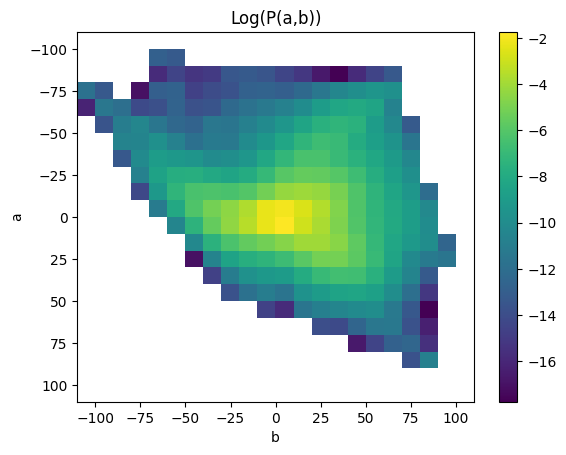

In [14]:
a = dataset_ab[:,0,:,:].reshape(1,-1)
a = torch.squeeze(a).numpy()
b = dataset_ab[:,1,:,:].reshape(1,-1)
b = torch.squeeze(b).numpy()

# Define the limits for the x and y axes
x_min, x_max = -110, 110
y_min, y_max = -110, 110

# Compute 2D histogram
hist, xedges, yedges = np.histogram2d(a, b, bins=22, range=[[x_min, x_max], [y_min, y_max]])

print(xedges)

print(len(x), '\n')
print(np.sum(hist), '\n')
print('Diff: ', len(x) - np.sum(hist))

hist_log = np.log((hist/np.sum(hist)))

# Plot the histogram in logarithmic scale
plt.imshow(hist_log, interpolation='nearest', extent=[x_min, x_max, y_max, y_min], origin='lower', aspect='auto')
plt.colorbar()
plt.xlabel('b')
plt.ylabel('a')
plt.title('Log(P(a,b))')
plt.show()

We now want to map each upperleft corner of a nonzero bin to its bin number

In [15]:
Q = np.sum(np.isfinite(hist_log))
print("With our dataset we get Q = ", Q)

With our dataset we get Q =  246


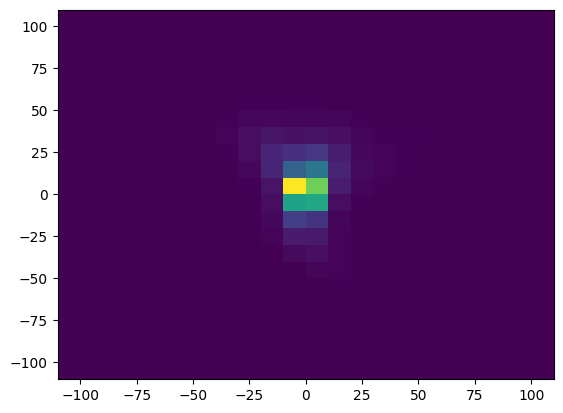

In [16]:
hist_obj = plt.hist2d(a, b, bins = 22, range=[[x_min, x_max], [y_min, y_max]])

In [17]:
#Keep track of where the grid points are
positions = []
indeces = []

index = 0

for i in range(len(hist_obj[1][:-1])):
  for j in range(len(hist_obj[2][:-1])):
    if hist_obj[0][i, j] > 0:
      positions.append((i,j))
      indeces.append(index)
      index += 1

dictionary = dict(zip(positions, indeces))
dictionary_inverse = dict(zip(indeces, positions)) # dictionary_inverse[132] --> (5, 7)

In [18]:
dictionary.keys()

dict_keys([(2, 18), (2, 19), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (5, 16), (5, 17), (5, 18), (5, 19), (6, 8), (6, 9), (6, 10), (6, 11), (6, 12), (6, 13), (6, 14), (6, 15), (6, 16), (6, 17), (6, 18), (6, 19), (7, 7), (7, 8), (7, 9), (7, 10), (7, 11), (7, 12), (7, 13), (7, 14), (7, 15), (7, 16), (7, 17), (7, 18), (7, 19), (8, 6), (8, 7), (8, 8), (8, 9), (8, 10), (8, 11), (8, 12), (8, 13), (8, 14), (8, 15), (8, 16), (8, 17), (8, 18), (8, 19), (8, 20), (9, 6), (9, 7), (9, 8), (9, 9), (9, 10), (9, 11), (9, 12), (9, 13), (9, 14), (9, 15), (9, 16), (9, 17), (9, 18), (9, 19), (9, 20), (10, 5), (10, 6), (10, 7), (10, 8), (10, 9), (10, 10), (10, 11), (10, 12), (10, 13), (10, 14), (10, 15), (10, 16), (10, 17), (10, 18), (10, 19), (11, 4), (11, 5), (11, 6), (11, 7), (11, 8), (11, 9), (11, 10), (11, 11), (11, 12), (11, 13), (11, 14), (11, 15), (11, 16), (11, 17), (11, 18), (1

## Store new dataset

In [ ]:
#Create ground truth Z_label

output_tensor = torch.zeros(50000, 1, 32, 32)

for image_number in range(dataset_ab.shape[0]):
  if image_number % 100 == 0:
    print("Image_nUmber : ", image_number)
  Z_image = np.zeros([1, 32, 32])
  image = dataset_ab[image_number, :, :, :]
  for i in range(32):
    for j in range(32):
#      print(image[:, i, j])
      couple = tuple(torch.Tensor.tolist(torch.Tensor.int((image[:, i,j] + torch.tensor([110, 110])) // 10)))
      index = dictionary[couple]
      Z_image[0, i, j] = index
  output_tensor[image_number, :, :, :] = torch.tensor(Z_image)

Image_nUmber :  0
Image_nUmber :  100
Image_nUmber :  200
Image_nUmber :  300
Image_nUmber :  400
Image_nUmber :  500
Image_nUmber :  600
Image_nUmber :  700
Image_nUmber :  800
Image_nUmber :  900
Image_nUmber :  1000
Image_nUmber :  1100
Image_nUmber :  1200
Image_nUmber :  1300
Image_nUmber :  1400
Image_nUmber :  1500
Image_nUmber :  1600
Image_nUmber :  1700
Image_nUmber :  1800
Image_nUmber :  1900
Image_nUmber :  2000
Image_nUmber :  2100
Image_nUmber :  2200
Image_nUmber :  2300
Image_nUmber :  2400
Image_nUmber :  2500
Image_nUmber :  2600
Image_nUmber :  2700
Image_nUmber :  2800
Image_nUmber :  2900
Image_nUmber :  3000
Image_nUmber :  3100
Image_nUmber :  3200
Image_nUmber :  3300
Image_nUmber :  3400
Image_nUmber :  3500
Image_nUmber :  3600
Image_nUmber :  3700
Image_nUmber :  3800
Image_nUmber :  3900
Image_nUmber :  4000
Image_nUmber :  4100
Image_nUmber :  4200
Image_nUmber :  4300
Image_nUmber :  4400
Image_nUmber :  4500
Image_nUmber :  4600
Image_nUmber :  4700
Imag

In [ ]:
#Convert to tensor form --> represents the features as one tensor 4D [index, 3, 32, 32]
dataset_l  = torch.cat([torch.unsqueeze(tens, 0) for tens in dataset_l])
dataset_Z = torch.Tensor.int(output_tensor)

#Set up new dataset
N_images = 40000
train = data_utils.TensorDataset(dataset_l[: N_images], dataset_Z[: N_images])
test = data_utils.TensorDataset(dataset_l[N_images:], dataset_Z[N_images: ])

In [ ]:
#Save dataset so we won't have to compute it again
#serialized_dataset_path = '/content/drive/MyDrive/CIFAR10/train_small.pkl'
pickle.dump(train, open("df_small_22.pkl", "wb"))

pickle.dump(test, open("df_small_22_test.pkl", "wb"))

In [ ]:
!cp df_small_22.pkl /content/gdrive/MyDrive/CIFAR10

In [ ]:
!cp df_small_22_test.pkl /content/gdrive/MyDrive/CIFAR10

## Load new dataset

In [19]:
objects = []
with (open("/content/gdrive/MyDrive/CIFAR10/df_small_22.pkl", "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break

with (open("/content/gdrive/MyDrive/CIFAR10/df_small_22_test.pkl", "rb")) as openfile:
    while True:
        try:
            objects.append(pickle.load(openfile))
        except EOFError:
            break


In [20]:
train = objects[0]
test = objects[1]

## Computation of $\vec{w}$

In [21]:
#Store indeces as tensor

position_tensor = torch.zeros([len(hist_obj[1][:-1]), len(hist_obj[2][:-1])] )
for position, index in zip(positions, indeces):
  position_tensor[position[0], position[1]] = index

position_tensor = torch.Tensor.int(position_tensor)

In [22]:
l = .85                                  # lambda
p = np.ndarray.flatten(hist_obj[0])
p = p[p > 0.]                           # p is a 1D array with the non-zero probabilities
p = p / np.sum(p)

Q = len(p)

w = 1 / ((1-l)*p + l/Q)
w = w / np.dot(w , p)

In [23]:
#Plot w to check if it's ok
zeros = np.zeros((22, 22))
for i in range(len(w)):
  zeros[dictionary_inverse[i]] = w[i]

Text(0.5, 1.0, 'w values')

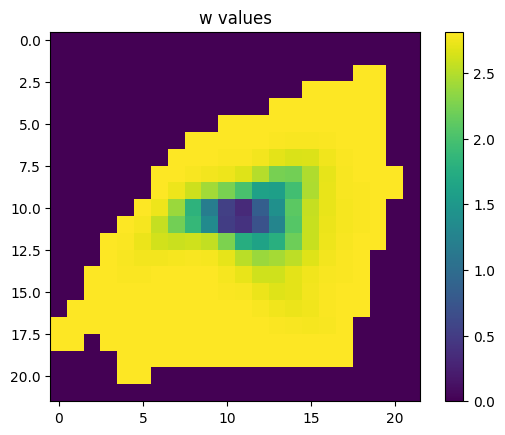

In [24]:
im = plt.imshow(zeros)
plt.colorbar(im)
plt.title("w values")

## Training (special loss)
We train the network, using the following loss:

$L_{cl} = - \sum_{h,w, q} v(Z_{hw}) Z_{h,w,q}\log(\hat{Z}_{hwq})$,  $v(Z_{hw}) = w_{q^*}$, where $q^*$ is the index of the corresponding bin. We encode the ground truth $Z_{h,w,q}$ using one-hot-encoding.

*Reminder: Z has the shape of (1, h, w, q)*.

In [44]:
#Data loader
batch_size = 100
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)

In [45]:
w = torch.tensor(w)
w = w.clone().detach()

<ipython-input-45-09271d3c61f3>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w = torch.tensor(w)


In [46]:
class network_model(nn.Module):
  def __init__(self):
    super(network_model, self).__init__()

    resnet = models.resnet18(weights = "IMAGENET1K_V1")                   # import all resnet18 already trained
    self.resnet_base = nn.Sequential(*list(resnet.children())[0:6])       # take the first 6 layers of resnet, which end with 128 channels

    for param in self.resnet_base.parameters():                           # freeze the parameter of resnet_base
      param.requires_grad = False


    # define our layers on top of resnet <-- output: Qx32x32              # create my additional model to put after resnet
    self.cnn_next = nn.Sequential(
      nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor = 2),
      nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor = 2),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, Q, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(Q),
      nn.ReLU(),
      nn.Upsample(scale_factor = 2)
    )

  def forward(self, input):
    y = self.resnet_base(input)                                           # first go through resnet
    z = self.cnn_next(y)                                                  # then go through our layers
    return z

In [50]:
network = network_model() #CNN
loss = nn.CrossEntropyLoss()       #We begin with a simple MSE loss function
optim = torch.optim.Adam(network.parameters(), lr=1e-3, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma = 0.9)

In [51]:
losses_train = []
losses_val = []

epochs = 100
patience = 10 #how many epochs of non decreasing validation we accept
min_val = 0 #minimum validation loss (initialized to a meaningless value - we will update it at the first epoch)

PATH = "/content/gdrive/MyDrive/CIFAR10/model_trained_horizontalflip.pt"

w = w.to(device)

v_prova = torch.ones([batch_size, 32, 32])


transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
])


with torch.autograd.set_detect_anomaly(False):
  for epoch in range(epochs):
    print("Epoch ", epoch)
    network.train() #Set it up for training
    i = 0
    ls = []
    for features, labels in train_loader:
      transformed_batch = torch.stack([transform(img) for img in features])
      features = transformed_batch
      features = features.to(device)
      labels = labels.to(device)
      network = network.to(device)



      now = time.time()
      predictions = network(features)
      then = time.time()
      # print("time for prediction, ", then - now)
      v = w[labels]

      zeros = torch.zeros(batch_size, Q, 32, 32, dtype = torch.float64).to(device)
      one_hot = zeros.scatter(dim = 1, index = labels.type(torch.int64), src = v)

      L = loss(predictions, one_hot)
      ls.append(L.item())

      optim.zero_grad()
      L.backward()
      optim.step()

      if i%50 == 0:
        print("Loss at iteration ",  i , " is ", L.item())
      i += 1
    losses_train.append(mean(ls))
    scheduler.step()

#########################################################################################

    #Validation loss
    network.eval()
    with torch.no_grad():
      val_batches = []
      for features, labels in test_loader:
        features = features.to(device)
        labels = labels.to(device)
        network = network.to(device)

        prediction_val = network(features)

        v = w[labels]
        zeros = torch.zeros(batch_size, Q, 32, 32, dtype = torch.float64).to(device)
        one_hot = zeros.scatter(dim = 1, index = labels.type(torch.int64), src = v)

        val_loss = loss(prediction_val, one_hot)
        val_batches.append(val_loss.item())
      print("At epoch ", epoch, " validation loss ", mean(val_batches))
      losses_val.append(mean(val_batches))

    #Early stopping
    if epoch == 1:
      min_val = mean(val_batches)

    if mean(val_batches) < min_val:
      min_val = mean(val_batches)
      torch.save({
            'epoch': epoch,
            'model_state_dict': network.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': min_val,
            }, PATH)

    #Early stopping: break if no new minimum was reached in the last *patience* epochs

    if epoch >= patience:
        condition = 0
        for index in range(patience):
          if losses_val[-(index + 1)] > min_val:
            condition += 1
        if condition == patience:
          print("Early stopping!")
          break

Epoch  0
Loss at iteration  0  is  5.449362147338298
Loss at iteration  50  is  5.448321139071322
Loss at iteration  100  is  5.022432997683631
Loss at iteration  150  is  5.054337748140055
Loss at iteration  200  is  4.74075842524955
Loss at iteration  250  is  4.489375497061733
Loss at iteration  300  is  4.485413595556834
Loss at iteration  350  is  4.621476127137313
At epoch  0  validation loss  4.5133869365365635
Epoch  1
Loss at iteration  0  is  4.243621795569884
Loss at iteration  50  is  4.663345462309944
Loss at iteration  100  is  4.581822532904563
Loss at iteration  150  is  4.67095619266068
Loss at iteration  200  is  4.032359106889603
Loss at iteration  250  is  4.334379960127326
Loss at iteration  300  is  4.271978032829933
Loss at iteration  350  is  4.130783694737714
At epoch  1  validation loss  4.2848597875667425
Epoch  2
Loss at iteration  0  is  4.442271874076055
Loss at iteration  50  is  4.321866148363775
Loss at iteration  100  is  4.18417400324042
Loss at itera

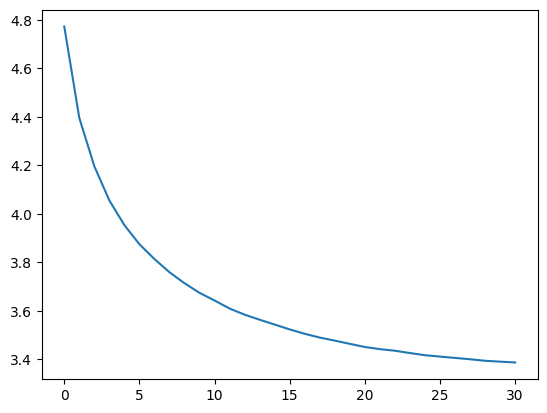

In [52]:
plt.plot(losses_train)

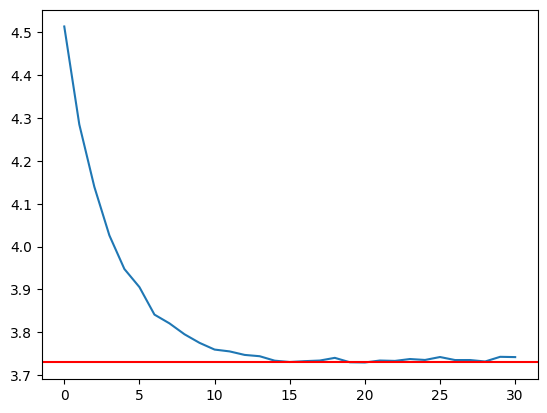

In [53]:
plt.plot(losses_val)
plt.axhline(y=min_val, color='r', linestyle='-')

In [54]:
min_val

3.729671697307872

## Give to the network the weights with minimum validation loss

In [55]:
checkpoint = torch.load(PATH)
network.load_state_dict(checkpoint['model_state_dict'])
optim.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

## Display output

In [56]:
input = test[-1][0].to(device)
output = network(torch.unsqueeze(input, 0))

In [57]:
input_cpu = input.cpu()
print(input_cpu)

tensor([[[91.2019, 93.9332, 93.5366,  ..., 87.6294, 88.9639, 89.0112],
         [88.3998, 94.7056, 92.9368,  ..., 89.1673, 90.7756, 84.7188],
         [83.4382, 92.3261, 92.4856,  ..., 88.0782, 87.8262, 81.9329],
         ...,
         [59.7789, 56.5216, 53.4283,  ..., 88.5202, 90.6640, 95.0701],
         [55.4080, 53.2554, 51.0047,  ..., 73.3379, 80.9646, 84.5305],
         [50.1521, 48.8447, 49.0463,  ..., 72.2587, 67.3161, 66.9412]],

        [[91.2019, 93.9332, 93.5366,  ..., 87.6294, 88.9639, 89.0112],
         [88.3998, 94.7056, 92.9368,  ..., 89.1673, 90.7756, 84.7188],
         [83.4382, 92.3261, 92.4856,  ..., 88.0782, 87.8262, 81.9329],
         ...,
         [59.7789, 56.5216, 53.4283,  ..., 88.5202, 90.6640, 95.0701],
         [55.4080, 53.2554, 51.0047,  ..., 73.3379, 80.9646, 84.5305],
         [50.1521, 48.8447, 49.0463,  ..., 72.2587, 67.3161, 66.9412]],

        [[91.2019, 93.9332, 93.5366,  ..., 87.6294, 88.9639, 89.0112],
         [88.3998, 94.7056, 92.9368,  ..., 89

In [58]:
input_cpu = input.cpu()
input_img = np.transpose(input_cpu, (1, 2, 0)).numpy()
print(input_img)
input_img_int = np.array(input_img, dtype=int)
# print(input_img_int)

print(input_img - input_img_int)

[[[91.20187  91.20187  91.20187 ]
  [93.93322  93.93322  93.93322 ]
  [93.536575 93.536575 93.536575]
  ...
  [87.629364 87.629364 87.629364]
  [88.9639   88.9639   88.9639  ]
  [89.0112   89.0112   89.0112  ]]

 [[88.39977  88.39977  88.39977 ]
  [94.705605 94.705605 94.705605]
  [92.936775 92.936775 92.936775]
  ...
  [89.16728  89.16728  89.16728 ]
  [90.77555  90.77555  90.77555 ]
  [84.718796 84.718796 84.718796]]

 [[83.43824  83.43824  83.43824 ]
  [92.32606  92.32606  92.32606 ]
  [92.48564  92.48564  92.48564 ]
  ...
  [88.07821  88.07821  88.07821 ]
  [87.826225 87.826225 87.826225]
  [81.932915 81.932915 81.932915]]

 ...

 [[59.778854 59.778854 59.778854]
  [56.521645 56.521645 56.521645]
  [53.428314 53.428314 53.428314]
  ...
  [88.520164 88.520164 88.520164]
  [90.66398  90.66398  90.66398 ]
  [95.070114 95.070114 95.070114]]

 [[55.408043 55.408043 55.408043]
  [53.25544  53.25544  53.25544 ]
  [51.004715 51.004715 51.004715]
  ...
  [73.33787  73.33787  73.33787 ]
  [8

In [59]:
output = torch.squeeze(output, 0)

In [60]:
#To go back from output to ab:

ab = torch.zeros(2, 32, 32)
ab_indeces = torch.zeros(2, 32, 32)

#take output and find maximum index along direction 3
argmax = torch.argmax(output, 0)
argmax = argmax.cpu()
argmax = argmax.numpy()

print(argmax)

#find corresponding (i,j) using inverse dictionary
a_entries = np.zeros([32, 32])
b_entries = np.zeros([32, 32])

for i in range(32):
  for j in range(32):
    index = argmax[i,j]
    index = int(index)
    a = dictionary_inverse[index][0]
    b = dictionary_inverse[index][1]

    a = (a + .5)*10 - 110
    a_entries[i,j] = a

    b = (b + .5)*10 - 110
    b_entries[i,j] = b

ab[0, : , : ] = torch.tensor(a_entries)
ab[1, : , : ] = torch.tensor(b_entries)

[[84 84 84 ... 84 84 84]
 [84 84 84 ... 84 84 84]
 [84 84 84 ... 84 84 84]
 ...
 [84 84 84 ... 68 84 84]
 [84 84 84 ... 84 84 84]
 [84 84 84 ... 84 84 84]]


In [61]:
input = input.cpu()
tensor1 = torch.squeeze(input)[0, : , :].cpu()
ab = ab.cpu()

rgb_attempt = LAB_to_RGB(torch.squeeze(input)[0, : , :], ab)

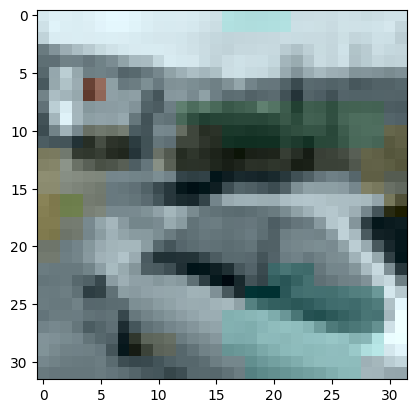

In [62]:
# plt.imshow(input_img_int)
# plt.axis('off')  # Turn off axis
# plt.show()

plt.imshow(torch.permute(rgb_attempt, [1,2,0]))
plt.show()

# High res image

In [116]:
from PIL import Image
image_adress = '/content/yosemite.jpg'
image_original = Image.open(image_adress)

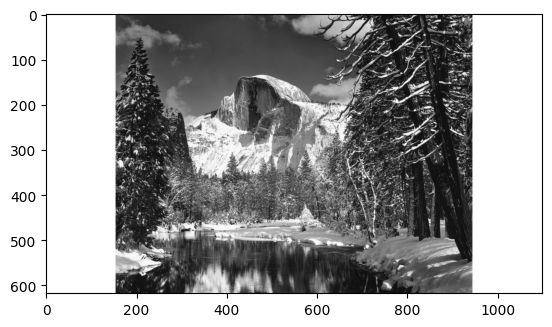

In [117]:
plt.imshow(image_original)

In [118]:
image_original = image_original.crop([200, 0, 800, 600])

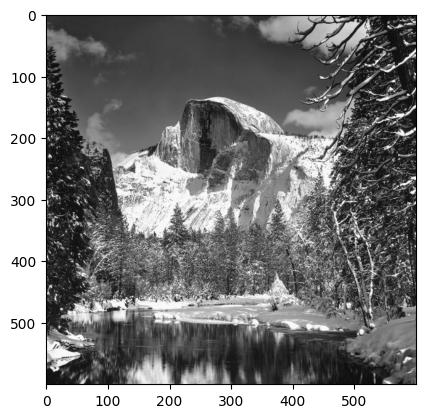

In [119]:
plt.imshow(image_original)

In [120]:
image_rgb = np.array(image_original)
image_lab = rgb2lab(image_rgb)
image_lab = torch.tensor(image_lab)

In [121]:
image_lab.shape

torch.Size([600, 600, 3])

In [122]:
image_lab = torch.permute(image_lab, [2, 0, 1])
image_lab.shape
transform = transforms.Resize([32, 32])
image_lab = transform(image_lab)

In [123]:
image_lab.shape

torch.Size([3, 32, 32])

In [124]:
bw = torch.zeros([3, 32 ,32])
bw[0, :, : ] = image_lab[0, :, :]
bw[1, :, : ] = image_lab[0, :, :]
bw[2, :, : ] = image_lab[0, :, :]

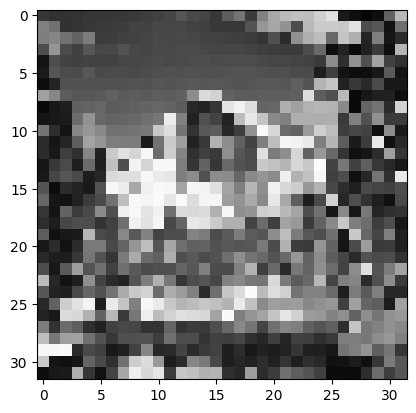

In [125]:
plt.imshow(torch.permute(bw/100, [1, 2, 0]).numpy())

In [126]:
network = network.to(device)
input = torch.unsqueeze(bw, 0)
input = input.to(device)
network.eval()
output = network(input)

In [127]:
output = output.squeeze(0)

In [128]:
output.shape

torch.Size([246, 32, 32])

In [129]:
#To go back from output to ab:

ab = torch.zeros(2, 32, 32)
ab_indeces = torch.zeros(2, 32, 32)

#take output and find maximum index along direction 3
argmax = torch.argmax(output, 0)
argmax = argmax.cpu()
argmax = argmax.numpy()

#find corresponding (i,j) using inverse dictionary
a_entries = np.zeros([32, 32])
b_entries = np.zeros([32, 32])

for i in range(32):
  for j in range(32):
    index = argmax[i,j]
    index = int(index)
    a = dictionary_inverse[index][0]
    b = dictionary_inverse[index][1]

    a = (a + .5)*10 - 110
    a_entries[i,j] = a

    b = (b + .5)*10 - 110
    b_entries[i,j] = b

ab[0, : , : ] = torch.tensor(a_entries)
ab[1, : , : ] = torch.tensor(b_entries)

In [130]:
input = input.cpu()
tensor1 = torch.squeeze(input)[0, : , :].cpu()
ab = ab.cpu()

rgb_attempt = LAB_to_RGB(torch.squeeze(input)[0, : , :], ab)

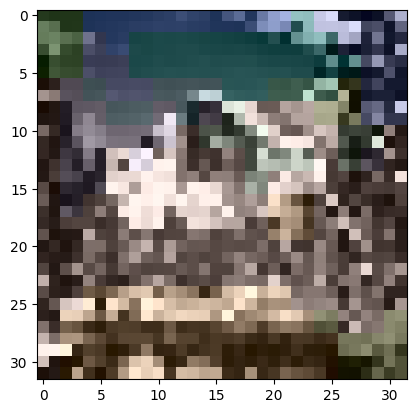

In [131]:
plt.imshow(torch.permute(rgb_attempt, [1,2,0]))
plt.show()